In [87]:
# Import Libraries 
# ----------------------------------------------
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [88]:
# Input Parameter
# ----------------------------------------------

# Discretization
c1=20          # Number of grid points per dominant wavelength
c2=0.75        # CFL-Number
nx=1000        # Number of grid points
T=0.6           # Total propagation time
nt=2405        # Number of time steps

# Source Signal
f0= 50         # Center frequency Ricker-wavelet
q0= 1          # Maximum amplitude Ricker-Wavelet
xscr = 49     # Source position (in grid points)

# Receiver
xrec=49       # Position Reciever (in grid points)

<IPython.core.display.Javascript object>


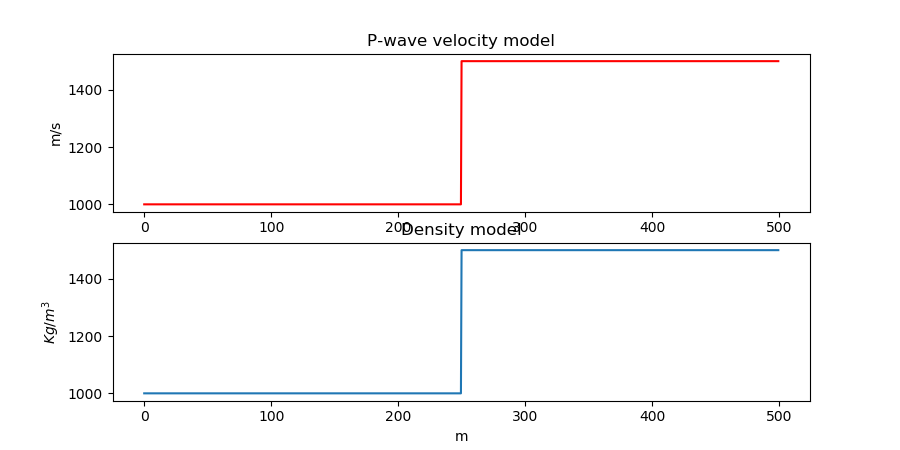

In [89]:
# Velocity and density
# P-wave velocity in m/s
model_v=np.zeros(nx)
for n in range(0,nx//2):
    model_v[n]=1000
    model_v[n+nx//2]=1500

# Density in g/cm^3
rho=np.zeros(nx)
for n in range(0,nx//2):
    rho[n]=1000
    rho[n+nx//2]=1500 

## Preparation 
# ----------------------------------------------

## Calculate first Lame-Paramter
l=rho*model_v**2

cmin=model_v.min()    # Lowest P-wave velocity
cmax=model_v.max()   # Highest P-wave velocity
fmax=2*f0               # Maximum frequency
dx=cmin/(fmax*c1)       # Spatial discretization (in m)
dt=dx/(cmax)*c2         # Temporal discretization (in s)
lambda_min=cmin/fmax    # Smallest wavelength

# Create space and time vector
x=np.linspace(0,(dx*nx-dx),nx) # Space vector
t=np.linspace(0,T-dt,nt)     # Time vector

# Plotting velocity and density model
plt.ion()
fig1 = plt.figure(figsize=(9,4.5))
plt.subplot(211)
plt.plot(x, model_v,'r')
plt.title('P-wave velocity model')
plt.ylabel('m/s')
#plt.xlabel('m')
plt.subplot(212)
plt.plot(x,rho)
plt.title('Density model')
plt.xlabel('m')
plt.ylabel('$Kg/m^3$')
plt.show()

<IPython.core.display.Javascript object>


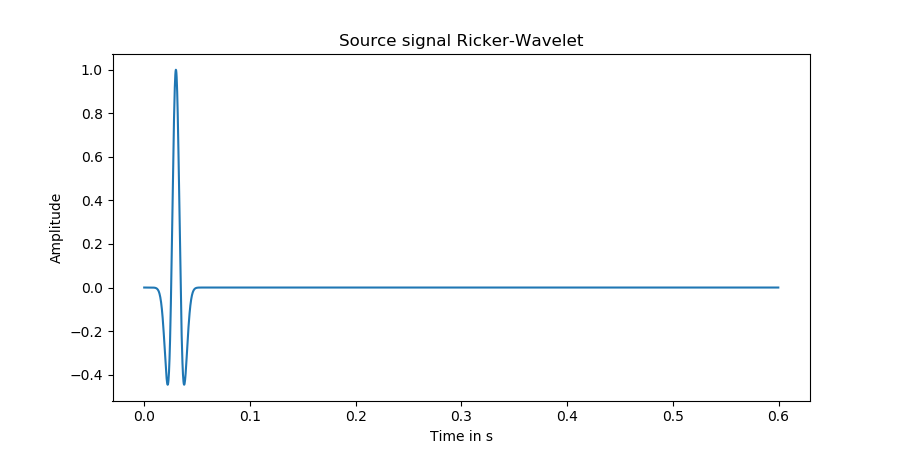

In [90]:
# Init wavefields
vx=np.zeros((nx,nt))
p=np.zeros((nx,nt))
pnew=np.zeros(nx)
vnew=np.zeros(nx)

# Source signal - Ricker-wavelet
#tau=np.pi*f0*(t-1.5/f0)
#q=q0*(1-2*tau**2)*np.exp(-tau**2)

pf=np.pi**2*f0**2
q=(1-2*pf*(t-1.5/f0)**2)*np.exp(-pf*(t-1.5/f0)**2)

# Plotting source signal
plt.ion()
fig2 = plt.figure(figsize=(9,4.5))
plt.plot(t,q)
plt.title('Source signal Ricker-Wavelet')
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.show()

# Init Seismograms
Seismogram=np.zeros(nt) # Three seismograms

<IPython.core.display.Javascript object>


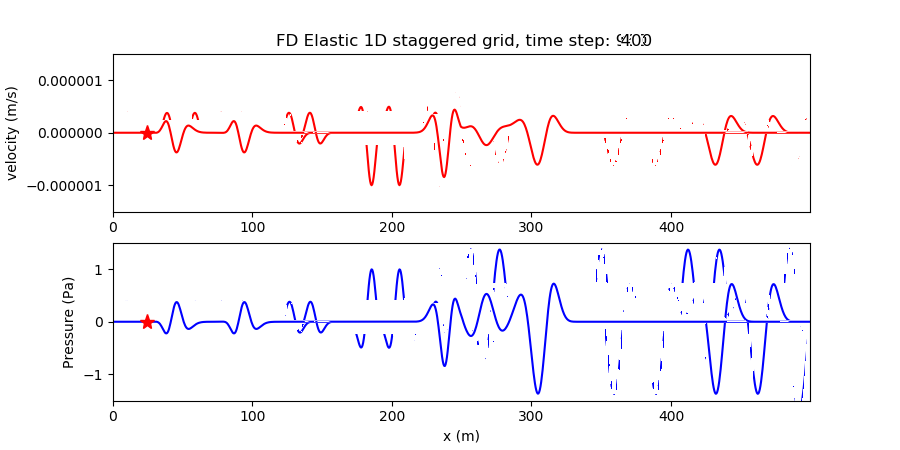

In [94]:
# First set up the figure, the axis, and the plot element we want to animate
title = "FD Elastic 1D staggered grid"
fig3 = plt.figure(figsize=(9,4.5))
#ax = plt.axes(xlim=(x.min(),x.max()), ylim=(-1.0,1.0))
ax1 = fig3.add_subplot(2, 1, 1)
ax2 = fig3.add_subplot(2, 1, 2)
up31, = ax1.plot(x, vnew, color = "red", lw = 1.5)  # plot velocity update each time step
up32, = ax2.plot(x, pnew, color = "blue", lw = 1.5) # plot pressure update each time step
leg1,= ax1.plot(xscr*dx, 0, 'r*', markersize=11) # plot position of the source and receiver in velocity plot
leg2,= ax2.plot(xscr*dx, 0, 'r*', markersize=11) # plot position of the source and receiver in pressure plot
ax1.set_ylabel('velocity (m/s)')
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(-1.5e-6,1.5e-6)
ax2.set_xlabel('x (m)')
ax2.set_ylabel('Pressure (Pa)')
ax2.set_xlim(x.min(),x.max())
ax2.set_ylim(-1.5,1.5)
plt.show()

# 1D Elastic Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------
## Time extrapolation

for n in range(1,nt-2):
    
    # Inject source wavelet
    p[xscr,:]=p[xscr,:]+q[n]
    
    # Update velocity
    for kx in range(1,nx-2):
        
            # Calculating spatial derivative
        p_x=( p[kx+1,n] -  p[kx,n])/dx

            # Update velocity
        vx[kx,n]=vx[kx,n-1]+dt/rho[kx]*p_x
        vnew=vx[:,n]
    
    # Update pressure
    for kx in range(1,nx-2):
        
            # Calculating spatial derivative
        vx_x= (vx[kx,n] - vx[kx-1,n])/dx
            # Update pressure
        p[kx,n+1]=p[kx,n]+l[kx]*dt*vx_x
        pnew=p[:,n]
                # Set Boundary Conditions    comment / uncomment
        p[0, n+1]  = 0;                # Fixed end
        p[nx-1, n+1] = 0;              # Fixed end
        vx[0, n+1]  = 0;               # Fixed end
        vx[nx-1, n+1] = 0;             # Fixed end
#        p[nx-1,n+1] = p[nx-2,n+1]      # Free end
#        vx[nx-1,n+1] = vx[nx-2,n+1]    # Free end
#        p[0,n+1] = p[1,n+1]            # Free end
#        vx[0,n+1] = vx[1,n+1]          # Free end
#        p[0,n+1]  = p[1,n]             # ABC
#        p[nx-1,n+1]  = p[nx-2,n]       # ABC
#        vx[0,n+1]  = vx[1,n]           # ABC
#        vx[nx-1,n+1]  = vx[nx-2,n]     # ABC
  
    # Save seismograms
    Seismogram[n]=p[xrec,n]
    idisp = 10 # display frequency
    if (n % idisp) == 0:
        #plt.title('Time Step (nt) = %d' % n)
        up31.set_ydata(vnew)
        up32.set_ydata(pnew)
        ax1.set_title(title + ", time step: %i" % (n)) 
        plt.gcf().canvas.draw()
plt.close()

<IPython.core.display.Javascript object>


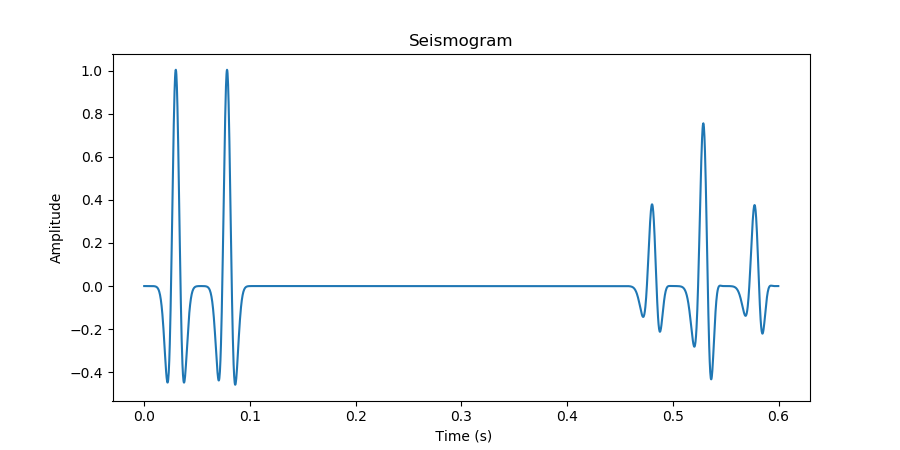

In [95]:
# Plot seismogram 
# ---------------
plt.ion()
fig4 = plt.figure(figsize=(9,4.5))
plt.plot(t, Seismogram)
plt.title('Seismogram')
plt.ylabel('Amplitude')
plt.xlabel(' Time (s)')
plt.show()